# Imports

In [726]:
# Usual stuff
import numpy as np
import matplotlib.pyplot as plt

# Scipy
import scipy as sp
import scipy.sparse as spr

# Typing
from typing import Callable

# Hamiltonian

We can now write the Hamiltonian including AFM and SC interaction as ([View more](https://www.notion.so/8-Superconducting-Instability-2a2b911af6a78021b002f7aad6a38266?pvs=21) - the SC is treated at the mean-field level):

$$
\begin{align*}

H &= \sum_{k=0}^{\pi/2} H_k

\end{align*}
$$

Where:

- $H_k$ couples the $\pm k$ modes with the $\pm k + \pi$ modes:
    
    $$
    \begin{align*}
    
    H_{k} &= H_k^\text{(HK + SC)} + H_{k+\pi}^\text{(HK + SC)}
    \\\\
    
    &\quad - J\sum_\sigma(n_{k\sigma} n_{k+\pi \bar \sigma} + n_{-k\sigma}n_{-k+\pi \bar \sigma})
    
    \end{align*}
    $$
    
- $H_k^\text{(HK + SC)}$  couples only the $\pm k$ modes:
    
    $$
    \begin{align*}
    
    H_k^\text{(HK + SC)}  &= \xi_k(n_k + n_{-k}) + U(n_{k\uarr}n_{k\darr} + n_{-k\uarr}n_{-k \darr})
    \\\\
    
    &\quad +\Delta^*(b_k + b_{-k}) + \Delta(b_k^\dag + b_{-k}^\dag)
    
    \end{align*}
    $$
    
- $b_k$ is the pair ladder operator for a Cooper pair:
    
    $$
    \begin{align*}
    
    b_k &= c_{-k\darr}c_{k\uarr}
    
    \end{align*}
    $$
    
- $\Delta$ has to be solved self-consistently for:
    
    $$
    \begin{align*}
    
    \Delta &= -\frac{g}{L_d}\sum_k\lang b_k\rang
    
    \end{align*}
    $$

We write the Hamiltonian in block-diagonal form, noticing that the number of particles pairs and the total spin are conserved, hence we get the following ten subspaces:
- **Parity of Particle Number**: Either $0$ or $1$.
- **Total Spin**: It is in the set $\pm4, \pm3, \pm2, \pm1, 0$.

## Helper Functions

In [727]:
def bissect(func: Callable, a: float, b: float, eps: float = 1e-6, maxI: int = 200, mult: bool = False) -> float:
    """
        Solves the equation `func(x) = 0` using the bissection method in [a, b].

        The function stops when the error is smaller then `eps` or the number of iterations exceeds `maxI`.

        The error is additive by default, but can be made multiplicative by setting `mult` = True

        ### Return
        x: The value of x that solves the equation.
    """

    # Evaluate on the edges
    fa, fb = func(a), func(b)

    # Check if there is a zero on the edges
    if abs(fa) <= 1e-16:
        return a
    elif abs(fb) <= 1e-16:
        return b

    # Main Loop
    i = 0
    error = (b-a)/2

    # For multiplicative error make sure to do at least one iteration
    if mult:
        error = eps + 1

    while abs(error) > eps:

        # Find the midpoint and evaluate the function there
        c = (a+b)/2
        fc = func(c)

        # Check if the zero is exactly on the midpoint
        if abs(fc) <= 1e-16:
            return c

        # Sign change happens in [a, c]
        elif fa * fc < 0:
            b = c
            fb = fc
        
        # Sign change happens in [c, b]
        elif fc * fb < 0:
            a = c
            fa = fc
        
        # No sign change
        else:
            raise ValueError(f"O sinal de f é o mesmo em a = {a} e em b = {b} (f(a) = {fa}, f(b) = {fb}) - iteração {i}).")

        # Compute the error
        error = (b - a)/2

        # If the error is multiplicative, compare the error with the midpoint value
        if mult:
            error /= (a+b)/2

        # Maximum number of iterations
        i += 1
        if i > maxI:
            raise ValueError(f"Não foi possível encontrar a raíz da função com a precisão desejada em menos de maxI = {maxI} iterações!")
        
    return (a+b)/2

In [728]:
def eps(kk: np.ndarray) -> np.ndarray:
    """
        Compute the dispersion relation for a given set of vectors `kk`.
    """
    return -2 * np.sum(np.cos(kk), axis = 0)


def fock(decimal: int, modes: int = 8) -> list[int]:
    return [(decimal >> n) % 2 for n in range(modes)][::-1]


# Sample code to convert from state to full fock space
# The four least significant bits (LSB) corresponds to k and the four MSBs corresponds to k+pi
state = 20
n_pk_ppi_u_i, n_pk_ppi_d_i, n_mk_ppi_u_i, n_mk_ppi_d_i, n_pk_npi_u_i, n_pk_npi_d_i, n_mk_npi_u_i, n_mk_npi_d_i = fock(state, 8)

We are using the basis:
$$
\begin{align*}
\ket{n_{k+\pi\uarr}, n_{k+\pi\darr}, n_{-k+\pi\uarr}, n_{-k+\pi\darr}, n_{k\uarr}, n_{k\darr}, n_{-k\uarr}, n_{-k\darr}}
\end{align*}
$$

## Subspaces

In [729]:
# CONSTANTS
MODES = 8
DIM = 2**MODES


# SUBSPACES
class Subspace:

    # Get properties and states
    # Technically we could even forget about the quantum numbers
    def __init__(self, parity: int, spin: int) -> None:
        # Quantum numbers of the subspace
        self.parity = parity
        self.spin = spin

        # States and dimension
        self.states = []
        self.dimension = 0
        self.Nk = 0

        # Lookup table
        self.lookup = dict()
    
    # Print
    def __str__(self) -> str:
        return f"Space with P = {self.parity} and S = {self.spin} contains {len(self.states)} states."

    
    # STATES
    
    # Add a state to the list
    def add_state(self, st: int) -> None:
        self.states += [st]

    # Build a lookup table {state: position} on the list
    def build_lookup(self) -> None:
        self.dimension = len(self.states)

        for index, st in enumerate(self.states):
            self.lookup[st] = index


    # OPERATORS

    # Create the operators
    def build_operators(self) -> tuple[np.ndarray, np.ndarray]:

        # Make sure we have a lookup table
        if len(self.lookup) == 0: self.build_lookup()

        # Operators (t for total, meaning both options)
        self.nk_tk_tpi_t = np.zeros((self.dimension, self.dimension), dtype=np.float64)
        self.bk_tk_tpi = np.zeros((self.dimension, self.dimension), dtype=np.float64)

        for st in self.states:
            # Position of the state
            ket = self.lookup[st]

            # Binary decomposition
            st_list = fock(st)
            n_pk_ppi_u, n_pk_ppi_d, n_mk_ppi_u, n_mk_ppi_d, n_pk_npi_u, n_pk_npi_d, n_mk_npi_u, n_mk_npi_d = st_list

            # Number of particles in the state
            self.nk_tk_tpi_t[ket, ket] = np.sum(st_list)

            # Applying bk to this state (st is the ket, we find the bra)
            # For the first and third lines, the phase is n_pk_npi_u-1 + n_pk_npi_d + n_mk_npi_u bu the first term is 0 because it is 1-1
            if n_mk_npi_d * n_pk_npi_u:
                bra_pk_npi = self.lookup[st - 8 - 1]
                self.bk_tk_tpi[bra_pk_npi, ket] += (-1)**(n_pk_npi_d + n_mk_npi_u)
            
            if n_pk_npi_d * n_mk_npi_u:
                bra_mk_npi = self.lookup[st - 4 - 2]
                self.bk_tk_tpi[bra_mk_npi, ket] += (-1)**(n_pk_npi_d)
            
            if n_pk_ppi_u * n_mk_ppi_d:
                bra_pk_ppi = self.lookup[st - 128 - 16]
                self.bk_tk_tpi[bra_pk_ppi, ket] += (-1)**(n_pk_ppi_d + n_mk_ppi_u)
            
            if n_pk_ppi_d * n_mk_ppi_u:
                bra_mk_ppi = self.lookup[st - 64 - 32]
                self.bk_tk_tpi[bra_mk_ppi, ket] += (-1)**(n_pk_ppi_d)
            
        return self.nk_tk_tpi_t, self.bk_tk_tpi
            
        

    def build_hamiltonian(self, Nk: int, ee_npi: np.ndarray, ee_ppi: np.ndarray, mu: float, U: float, Delta: complex, J: float) -> np.ndarray:

        # Number of k-points
        self.Nk = Nk

        # Dispersion relation
        xi_npi = ee_npi - mu
        xi_ppi = ee_ppi - mu

        # Hamiltonian
        self.ham = np.zeros((Nk, self.dimension, self.dimension), dtype=np.float64)

        # Diagonal
        for st in self.states:
            # Position of the state
            ket = self.lookup[st]

            # Binary decomposition
            st_list = fock(st)
            n_pk_ppi_u, n_pk_ppi_d, n_mk_ppi_u, n_mk_ppi_d, n_pk_npi_u, n_pk_npi_d, n_mk_npi_u, n_mk_npi_d = st_list

            # Kinetic Energy
            self.ham[:, ket, ket] += xi_npi * np.sum(n_pk_npi_u + n_pk_npi_d + n_mk_npi_u + n_mk_npi_d)
            self.ham[:, ket, ket] += xi_ppi * np.sum(n_pk_ppi_u + n_pk_ppi_d + n_mk_ppi_u + n_mk_ppi_d)

            # HK Interaction
            self.ham[:, ket, ket] += U * (n_pk_ppi_u * n_pk_ppi_d + n_mk_ppi_u * n_mk_ppi_d + n_pk_npi_u * n_pk_npi_d + n_mk_npi_u * n_mk_npi_d)

            # AFM Interaction
            self.ham[:, ket, ket] += -J * (n_pk_npi_u * n_pk_ppi_d + n_mk_npi_u * n_mk_ppi_d + n_pk_npi_d * n_pk_ppi_u + n_mk_npi_d * n_mk_ppi_u)

        # Off-diagonal
        self.ham += np.conjugate(Delta) * self.bk_tk_tpi
        self.ham += Delta * np.transpose(np.conjugate(self.bk_tk_tpi))

        # with np.printoptions(precision=3, suppress=True, threshold=100_000, linewidth=200):
        #     print(f"The space is (P, S) = ({self.parity}, {self.spin})")

        #     print(f"The Hamiltonian is:")
        #     print(self.ham)

        return self.ham



def generate_fspace() -> dict[tuple[int, int], Subspace]:
    """
        Generate the Fock space for our problem.
    """

    # Create all spaces (types so we can have hints)
    fspace = dict[tuple[int, int], Subspace]()
    for parity in [0, 1]:
        for spin in range(-4, 5):
            # If we have an even number of particles then spin must be even
            if abs(spin) % 2 == parity:
                fspace[(parity, spin)] = Subspace(parity, spin)


    # STATES
    for st in range(DIM):

        # Compute parity
        parity = np.sum([(st >> n) % 2 for n in range(MODES)]) % 2

        # Compute spin
        spin = np.sum([(st >> (2*n + 1)) % 2 for n in range(MODES//2)]) - np.sum([(st >> (2*n)) % 2 for n in range(MODES//2)])

        # Add state to correct subspace
        fspace[(parity, spin)].add_state(st)


    # Build lookup tables
    # Check size of spaces, and that they add to the whole space
    maxi = 0
    total = 0
    for key in fspace:
        fspace[key].build_lookup()
        maxi = np.max([maxi, len(fspace[key].states)])
        total += len(fspace[key].states)

    return fspace

    print(f"Is the total number of states 256? {"Yes" if total == 256 else "No"}")
    print(f"The biggest space has {maxi} states.")

## Thermal Average

In [730]:
def thermal_average(fspace: dict[tuple[int, int], Subspace], eigen: dict[tuple[int, int], tuple[np.ndarray, np.ndarray]], opcode: str, T: float, E0) -> float:

    # Number of k-points
    Nk = fspace[(0, -4)].Nk

    # Partition function
    Z = np.zeros(Nk)

    # Boltzmann weights
    bb = dict()


    for key in fspace:
        # Get eigenvalues and eigenvecs
        vals, _ = eigen[key]

        # Minimum energy, to scale Boltzmann factors
        valsE0 = vals - E0[:, None]

        # Boltzmann exponential
        bexp = np.exp(-valsE0/T)
        bb[key] = bexp

        # Compute partition function (sum over all dim states for each k)
        Z += np.sum(bexp, axis = 1)

    # Compute Boltzmann factor
    for key in eigen:

        # Divide by partition function
        bb[key] /= Z[:, None]
    
    # Compute average via a trace
    res = 0
    for key in fspace:
        
        # Get eigenvalues and eigenvecs
        vals, vecs = eigen[key]
        
        # Choose operator
        op = getattr(fspace[key], opcode)
        
        # Choose Boltzman factor
        bfac = bb[key]

        # Operator times the kets
        temp = op @ vecs
        
        # Bra times (op |ket>) via expectation[k, i] = sum_j conj(vecs[k, j, i]) * temp[k, j, i]
        expectation = np.einsum("kji,kji->ki", vecs.conj(), temp)

        # Sum over i and k with 
        res += np.sum(bfac * expectation)

    return res

## Solving the Hamiltonian

In [731]:
def solve(L: int, d: int, mu: float, U: float, g: float, J: float, T: float, delta_start: float = 1e-2, delta_eps: float = 1e-4):
    """
        Solve the mean-field Hamiltonian for `L` k-points along each `d` directions for temperature `T` and chemical potential `mu`.

        Self-consistently compute Delta starting at `delta_start` with an error of `delta_eps`.
    """

    # Possible adjustments
    # Take out the [:-1] from kk
    # Change the kx > 0 into kx >= 0


    # OBTAINING K-POINTS

    # Determine values of k in our lattice
    kk = np.linspace(-np.pi, np.pi, L + 1)[:-1]

    # Make a mesh of k values
    grid_kk = np.meshgrid(*[kk]*d, indexing='ij')

    # Convert to a single array with shape (d, L ** d)
    mesh_kk = np.stack(grid_kk).reshape(d, len(kk) ** d)

    # Select only 0 <= kx <= np.pi/2
    mesh_kk = mesh_kk[:, (0 <= mesh_kk[0]) *  (mesh_kk[0] < np.pi/2)]

    # Compute corresponding energies
    ee_npi = eps(mesh_kk)
    ee_ppi = eps(mesh_kk + np.pi)

    # Number of k-points
    Nk = len(mesh_kk[0])


    # SET UP FOCK SPACE

    # Generate the space
    fspace = generate_fspace()

    # Prepare the subspaces
    for key in fspace:
        fspace[key].build_operators()


    # SELF-CONSISTENT CALCULATION OF DELTA

    delta_error = delta_eps + 1
    while delta_error > delta_eps:
        
        # Solve the Hamiltonian
        E0 = np.zeros(Nk) + 1e6
        eigen = dict()
        for key in fspace:

            # Generate Hamiltonian
            ham = fspace[key].build_hamiltonian(Nk, ee_npi, ee_ppi, mu, U, delta_start, J)

            # Diagonalize Hamiltonians
            vals, vecs = np.linalg.eigh(ham)

            # Save the results
            eigen[key] = (vals, vecs)
        
            # Compute minimum energy for each k-point
            E0 = np.minimum(E0, np.min(vals, axis=1))
            
        # Compute the component of delta for this subspace
        delta_new = thermal_average(fspace, eigen, "bk_tk_tpi", T, E0)
        
        delta_new *= -g / (4 * Nk)

        # Compute error
        delta_error = np.abs(delta_start - delta_new)

        # Prepare next loop
        delta_start = delta_new
    

    # SOLVE FOR CONVERGED DELTA
    E0 = np.zeros(Nk) + 1e6
    eigen = dict()
    for key in fspace:

        # Generate Hamiltonian
        ham = fspace[key].build_hamiltonian(Nk, ee_npi, ee_ppi, mu, U, delta_start, J)
        
        # Diagonalize Hamiltonians
        vals, vecs = np.linalg.eigh(ham)

        # Save the results
        eigen[key] = (vals, vecs)
    
        # Compute minimum energy for each k-point
        E0 = np.minimum(E0, np.min(vals, axis=1))

    # Compute expectation values
    delta = thermal_average(fspace, eigen, "bk_tk_tpi", T, E0)
    n = thermal_average(fspace, eigen, "nk_tk_tpi_t", T, E0)


    # Normalize
    n /= (4 * Nk)
    delta_new *= -g / (4 * Nk)

    return np.abs(delta), n

In [732]:
# PARAMETERS
L = 100
d = 1
U = 1
mu = 0.5
g = 1.5
J = 0.2
T = 0.01

# Example CALCULATION
Delta, n = solve(L, d, mu, U, g, J, T)

## Computing $T_c$ for $J = 0$

Progress: 6/6

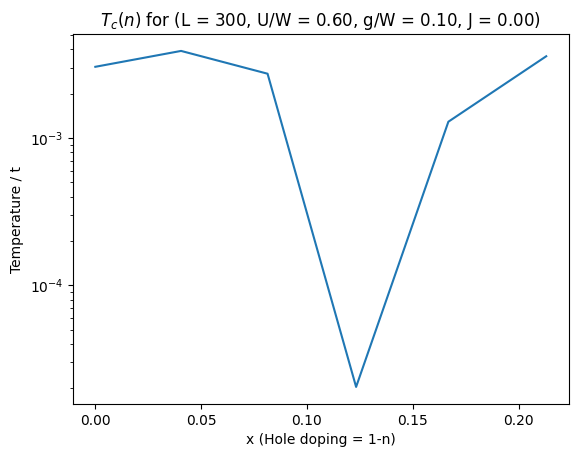

Progress: 6/6

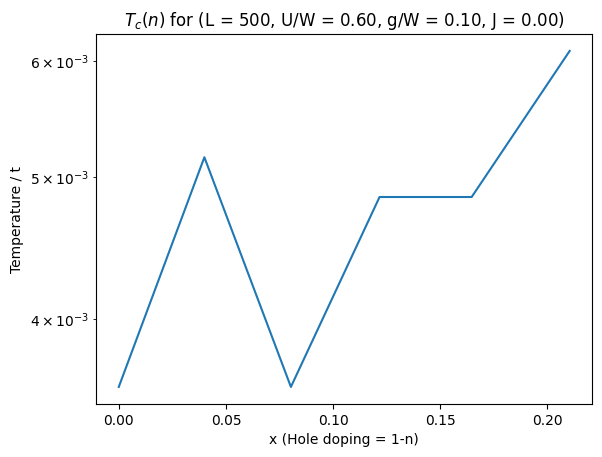

Progress: 6/6

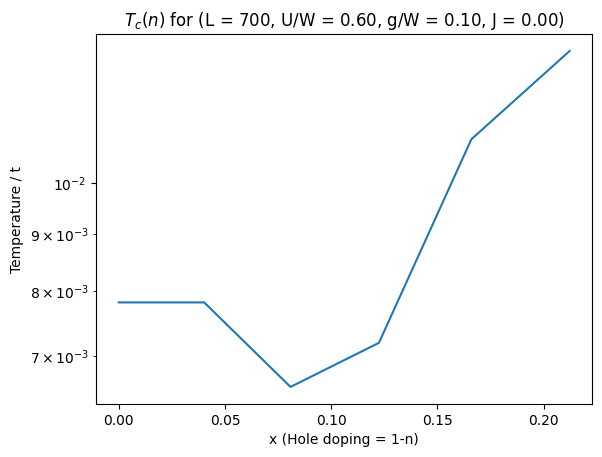

In [ ]:
# CONSTANTS
d = 1
W = 4

# PARAMETERS
# L = 300
g = 0.1 * W
U = 0.6 * W
J = 0

# Range of mu to compute
mu_min = U/2 - 0.5
mu_max = U/2 + 0.0
mu_steps = 6

mm = np.linspace(mu_min, mu_max, mu_steps)

# Range of T to study
tt_min = 1e-6 * W
tt_max = 5e-3 * W

# Threshold for delta (error is 0.01 times this)
delta_zero = 0.1


# CALCULATION
for L in [300, 500, 700]:

    # Find Tc(mu)
    tt = []
    for index, mu in enumerate(mm):
        Tc = bissect(lambda T: solve(L, d, mu, U, g, J, T, delta_start=10*delta_zero, delta_eps=1e-3*delta_zero)[0] - delta_zero, tt_min, tt_max, eps=0.05, mult=True)
        tt += [Tc]

        print(f"\rProgress: {index + 1}/{len(mm)}", end="")


    # Find Tc(n)
    nn = []
    for index in range(len(mm)):
        mu, T = mm[index], tt[index]
        delta, n = solve(L, d, mu, U, g, J, T, delta_start=10*delta_zero, delta_eps=0.1*delta_zero)

        nn += [n]

    # Pass to array
    tt = np.array(tt)
    nn = np.array(nn)

    plt.title(f"$T_c(n)$ for (L = {L}, U/W = {U/W:.2f}, g/W = {g/W:.2f}, J = {J/W:.2f})")
    plt.plot(1 - nn, tt)
    plt.xlabel("x (Hole doping = 1-n)")
    plt.ylabel("Temperature / t")
    plt.yscale("log")
    plt.show()

In [734]:
# # CONSTANTS
# d = 1
# W = 4

# # PARAMETERS
# L = 300
# g = 0.1 * W
# U = 0.6 * W
# J = 0

# # Range of mu to compute
# mu_min = U/2 - 0.5
# mu_max = U/2 + 0.0
# mu_steps = 6

# mm = np.linspace(mu_min, mu_max, mu_steps)

# # Range of T to study
# tt_min = 1e-6 * W
# tt_max = 1e-3 * W
# tt_steps = 20
# tt = np.exp(np.linspace(np.log(tt_min), np.log(tt_max), tt_steps))

# # Threshold for delta (error is 0.01 times this)
# delta_zero = 0.1

# # CALCULATION
# cc = []
# nn = []
# for mu in mm:
#     nn_temp = []
#     dd = []
#     for T in tt:
#         delta, n = solve(L, d, mu, U, g, J, T, delta_eps=0.001*delta_zero)
#         nn_temp += [n]
#         dd += [delta]

#     # Pass to array
#     nn_temp = np.array(nn_temp)
#     dd = np.array(dd)

#     plt.plot(tt/W, dd, label=f"x = {1-np.average(nn_temp):.3f} $\\pm$ {np.std(nn_temp):.2e}")

#     plt.title(f"$\\Delta$ for (L = {L}, U/W = {U/W:.2f}, g/W = {g/W:.2f}, J = {J/W:.2f})")
#     plt.xlabel("Temperature / W")
#     plt.xscale("log")
#     plt.ylabel("$\\Delta$")
#     plt.legend(bbox_to_anchor=(1.3, 1.0))
#     plt.show()
    
#     # Find Tc as the  temperature where Delta > delta_zero
#     Tc = np.max(tt[dd > delta_zero])
#     cc += [Tc]

#     # # Find Tc as the point with biggest derivative dDelta/dT
#     # dDdT = np.abs((dd[1:] - dd[:-1]) / (tt[1:] - tt[:-1]))
#     # maxi = np.max(dDdT)
#     # index = list(dDdT).index(maxi)

#     # # Use the midpoint
#     # Tc = (tt[index] + tt[index + 1]) / 2
#     # cc += [Tc]

#     # Compute n for Tc
#     delta, n = solve(L, d, mu, U, g, J, Tc, delta_eps=0.001*delta_zero)
#     nn += [n]

# # Pass to array
# nn = np.array(nn)
# cc = np.array(cc)

# print(nn)

# plt.title(f"$T_c(n)$ for (L = {L}, U/W = {U/W:.2f}, g/W = {g/W:.2f}, J = {J/W:.2f})")
# plt.plot(1 - nn, cc / W)
# plt.xlabel("x (Hole doping = 1-n)")
# plt.ylabel("Temperature / W")
# plt.yscale("log")
# plt.show()

## Filling $n(\mu)$ for a 1D Tight-Binding Chain

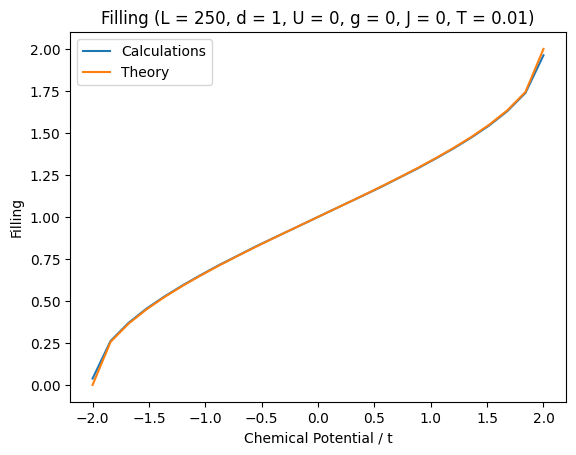

In [735]:
# PARAMETERS
L = 250
d = 1
U = 0
g = 0
J = 0
T = 0.01


# MU SWEEP
mu_start = -2*d - U
mu_end = -mu_start
mu_steps = int(L/10)


# Calculations
mm = np.linspace(mu_start, mu_end, mu_steps+1)
nn = []
for mu in mm:

    # Solve the Hamiltonian
    Delta, n = solve(L, d, mu, U, g, J, T)

    # Save the filling
    nn += [n]

plt.title(f"Filling (L = {L}, d = {d}, U = {U}, g = {g}, J = {J}, T = {T})")
plt.ylabel("Filling")
plt.xlabel("Chemical Potential / t")
plt.plot(mm, nn, label="Calculations")
plt.plot(mm, (2 / np.pi) * np.arccos(-0.5 * mm), label="Theory")
plt.legend()
plt.show()

## Previous Attempt - Hamiltonian with SymPy

In [736]:
'''
# We are using the notation npku as "n plus k up"
def ham():
    """
        Create the Hamiltonian Hk symbolically.
    """

    # Dimension of the Fock space
    dim = 16

    # Build the Hamiltonian
    Hk = sp.zeros(dim, dim)

    # Symbols
    xi, U, Delta = sp.symbols("xi, U, Delta")
    Delta_star = sp.conjugate(Delta)
    
    # Diagonal terms
    for i in range(dim):
        npku, npkd, nmku, nmkd = fock(i)
        Hk[i, i] += xi * (npku + npkd + nmku + nmkd)
        Hk[i, i] += U * (npku * npkd + nmku * nmkd)
    
    # Off-diagonal terms, taking into account the phase factor!
    # I will do only the destruction terms, as the creation ones are obtained by conjugation.
    for i in range(dim):
        for j in range(dim):
            npkui, npkdi, nmkui, nmkdi = fock(i)
            npkuj, npkdj, nmkuj, nmkdj = fock(j)

            Hk[i, j] += Delta_star * ((-1)**(npkuj - 1 + npkdj + nmkuj) * ((npkui + 1) == npkuj) * ((nmkdi + 1) == nmkdj) * (npkdi == npkdj) * (nmkui == nmkuj) + 
                                      (-1)**(npkdj) * ((nmkui + 1) == nmkuj) * ((npkdi + 1) == npkdj) * (npkui == npkuj) * (nmkdi == nmkdj))
    
    # Hermitian conjugate
    for i in range(dim):
        for j in range(dim):
            if i != j and Hk[j, i] == 0:
                Hk[j, i] += sp.conjugate(Hk[i, j])
    
    return Hk


def solve(N: int, d: int, U: float, mu: float):
    """
        Solve the mean-field Hamiltonian for N k-points along each d directions.
    """

    # Get the Hamiltonian
    Hk = ham()

    print("Hamiltonian:")
    print(sp.latex(Hk))

    # Diagonalize the Hamiltonian
    (vecs, vals) = Hk.diagonalize(sort=True, normalize=True)

    print("\nEigenvectors:")
    print(sp.latex(vecs))
    print(sp.latex(vals))

    print("\nEigenvectors in string form:")
    print(str(vecs))
    print(str(vals))

'''

'\n# We are using the notation npku as "n plus k up"\ndef ham():\n    """\n        Create the Hamiltonian Hk symbolically.\n    """\n\n    # Dimension of the Fock space\n    dim = 16\n\n    # Build the Hamiltonian\n    Hk = sp.zeros(dim, dim)\n\n    # Symbols\n    xi, U, Delta = sp.symbols("xi, U, Delta")\n    Delta_star = sp.conjugate(Delta)\n    \n    # Diagonal terms\n    for i in range(dim):\n        npku, npkd, nmku, nmkd = fock(i)\n        Hk[i, i] += xi * (npku + npkd + nmku + nmkd)\n        Hk[i, i] += U * (npku * npkd + nmku * nmkd)\n    \n    # Off-diagonal terms, taking into account the phase factor!\n    # I will do only the destruction terms, as the creation ones are obtained by conjugation.\n    for i in range(dim):\n        for j in range(dim):\n            npkui, npkdi, nmkui, nmkdi = fock(i)\n            npkuj, npkdj, nmkuj, nmkdj = fock(j)\n\n            Hk[i, j] += Delta_star * ((-1)**(npkuj - 1 + npkdj + nmkuj) * ((npkui + 1) == npkuj) * ((nmkdi + 1) == nmkdj) * (np

Result:

$$
\left[\begin{array}{cccccccccccccccc}0 & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0 & 0 & \overline{\Delta} & 0 & 0 & 0 & 0 & 0 & 0\\0 & \xi & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0 & 0 & 0 & 0\\0 & 0 & 0 & U + 2 \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0 & 0\\0 & 0 & 0 & 0 & 0 & 2 \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\- \Delta & 0 & 0 & 0 & 0 & 0 & 2 \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \overline{\Delta}\\0 & - \Delta & 0 & 0 & 0 & 0 & 0 & U + 3 \xi & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & \xi & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta} & 0\\\Delta & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 \xi & 0 & 0 & 0 & 0 & 0 & - \overline{\Delta}\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 2 \xi & 0 & 0 & 0 & 0 & 0\\0 & 0 & - \Delta & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & U + 3 \xi & 0 & 0 & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & U + 2 \xi & 0 & 0 & 0\\0 & 0 & 0 & 0 & - \Delta & 0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & U + 3 \xi & 0 & 0\\0 & 0 & 0 & 0 & 0 & 0 & 0 & 0 & - \Delta & 0 & 0 & 0 & 0 & 0 & U + 3 \xi & 0\\0 & 0 & 0 & 0 & 0 & 0 & \Delta & 0 & 0 & - \Delta & 0 & 0 & 0 & 0 & 0 & 2 U + 4 \xi\end{array}\right]
$$